1. Let's consider projection of our dataset to one-dimensional space of ith feature.

    a) m<sub>H</sub>(N) = N + 1
    
    We have N + 1 ways to mark possibly empty prefix of points as negative and the rest as positive.
    
    Breakpoint k = 2 since 2 + 1 != 2<sup>2</sup>.
    
    d<sub>VC</sub>(h) = k - 1 = 1 
    
    b) m<sub>H</sub>(N) = (N + 1)N / 2 + 1
    
    We have 'N + 1 choose 2' ways to select not empty positive center. Plus the case of entire negative dataset.
    
    Breakpoint k = 3 since 7 != 2<sup>3</sup>.
    
    d<sub>VC</sub>(h) = k - 1 = 2


In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import norm
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from random import shuffle


def read_dataset(dataset, to_labels=None):
    data = pd.read_csv(dataset)
    Y = data['label'].to_numpy()
    X = data.drop('label', axis=1).to_numpy()
    if to_labels:
        Y = np.array([to_labels[y] for y in Y])
    return X, Y


X, Y = read_dataset('blobs2.csv', {0: -1, 1: 1})
train, test, labels_train, labels_test = train_test_split(X, Y, test_size=0.20)


def error(hyp, Y):
    return np.sum(hyp != Y) / Y.shape[0]


def pocket_perceptron(train, labels_train, test, labels_test, iterations=1000, degree=1):
    features = PolynomialFeatures(degree)
    train = features.fit_transform(train)
    test = features.fit_transform(test)
    w_opt = w = np.random.uniform(-1, 1, train.shape[1])
    hyp_train = np.sign(np.dot(train, w))
    hyp_test = np.sign(np.dot(test, w))
    error_opt = error(hyp_test, labels_test)
    print(f'init error {error_opt}')
    for i in tqdm_notebook(range(iterations)):
        diff = hyp_train != labels_train
        idx = np.random.choice(range(np.sum(diff)))
        w += labels_train[diff][idx] * train[diff][idx]
        hyp_test = np.sign(np.dot(test, w))
        hyp_train = np.sign(np.dot(train, w))
        err = error(hyp_test, labels_test)
        if err < error_opt:
            error_opt = err
            print(f'error on test {error_opt}')
            w_opt = w 
    return w_opt


def plot(X, Y, contour, delta=0.01):
    X_pos = X[Y == 1]
    X_neg = X[Y == -1]
    plt.scatter(X_pos[:, 0], X_pos[:, 1])
    plt.scatter(X_neg[:, 0], X_neg[:, 1])
    grid_x = np.arange(np.min(X[:, 0]), np.max(X[:, 0]), delta)
    grid_y = np.arange(np.min(X[:, 1]), np.max(X[:, 1]), delta)
    X, Y = np.meshgrid(grid_x, grid_y)
    plt.contour(X, Y, contour(X, Y), [0])

init error 0.495


error on test 0.47
error on test 0.11
error on test 0.04
error on test 0.03
error on test 0.025
error on test 0.02
error on test 0.015
error on test 0.01



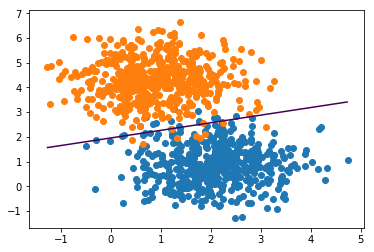

In [46]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2])

init error 0.855


error on test 0.505
error on test 0.275
error on test 0.09
error on test 0.04
error on test 0.03
error on test 0.02
error on test 0.015
error on test 0.01



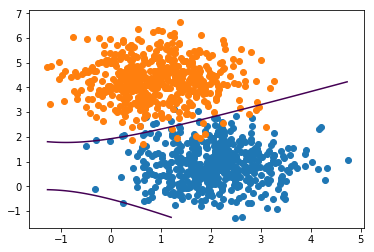

In [58]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test, degree=2)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2] + x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5])

init error 0.445


error on test 0.045
error on test 0.035
error on test 0.03
error on test 0.025
error on test 0.02
error on test 0.015
error on test 0.01
error on test 0.005



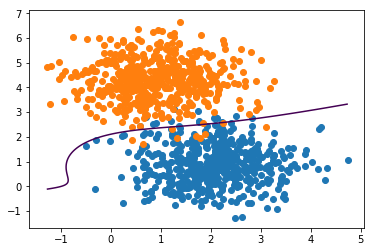

In [51]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test, degree=3)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2] + x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] +
                        x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9])

init error 0.495


error on test 0.38
error on test 0.365
error on test 0.245
error on test 0.215
error on test 0.145
error on test 0.14
error on test 0.105
error on test 0.095
error on test 0.08
error on test 0.05
error on test 0.04
error on test 0.035
error on test 0.03
error on test 0.02
error on test 0.015
error on test 0.01
error on test 0.005



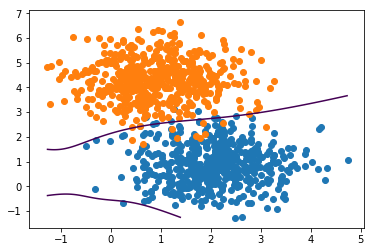

In [56]:
w = pocket_perceptron(train.copy(), labels_train, test.copy(), labels_test, degree=4)
plot(X, Y, lambda x, y: w[0] + x * w[1] + y * w[2] + x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] + 
                        x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9] + 
                        x ** 4 * w[10] + x ** 3 * y * w[11] + (x * y) ** 2 * w[12] + x * y ** 3 * w[13] + 
                        y ** 4 * w[14])

In [134]:
def scale(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)
    
    
def polynomial_features(X, degree=1):
    features = PolynomialFeatures(degree)
    return features.fit_transform(X)


def batches(X, batch_size):
    indicies = np.random.permutation(X.shape[0])
    for i in range(0, indicies.shape[0], batch_size):
        yield indicies[i : i + batch_size]
        
        
def accuracy(X, Y, w):
    return np.sum(np.sign(np.dot(X, w)) == Y) / Y.shape[0]
    
    
def logistic_regression(train, labels_train, test, labels_test, batch_size=50, epochs=50, learning_rate=0.1):
    w = np.random.uniform(-1, 1, train.shape[1])
    accuracies = []
    for epoch in tqdm_notebook(range(epochs)):
        for batch in batches(train, batch_size):
            gradient = np.zeros(w.shape)
            for i in batch:
                y = labels_train[i]
                x = train[i]
                gradient += y * x / (1 + np.exp(y * np.dot(w, x)))
            w += learning_rate * gradient / len(batch)
        accuracies.append(accuracy(test, labels_test, w))
    return accuracies

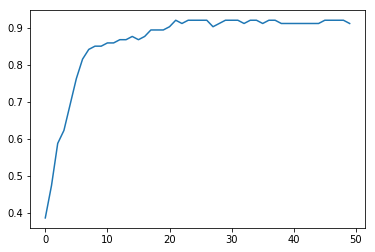

In [135]:
X, Y = read_dataset('cancer.csv', {'M': 1, 'B': -1})
X = scale(X)
X = polynomial_features(X)

train, test, labels_train, labels_test = train_test_split(X, Y, test_size=0.2)
accuracies = logistic_regression(train, labels_train, test, labels_test)
plt.plot(range(len(accuracies)), accuracies)

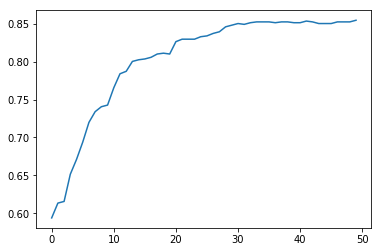

In [136]:
X, Y = read_dataset('spam.csv', {1: 1, 0: -1})
X = scale(X)
X = polynomial_features(X)

train, test, labels_train, labels_test = train_test_split(X, Y, test_size=0.2)
accuracies = logistic_regression(train, labels_train, test, labels_test)
plt.plot(range(len(accuracies)), accuracies)

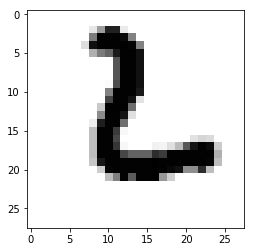

In [379]:
X, Y = read_dataset('mnist.csv')
X = X.reshape(-1, 28, 28)
plt.imshow(X[1337], cmap='Greys')

In [337]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten


def compile_model(activation, input_shape):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3,3), input_shape=input_shape))
    model.add(Conv2D(8, kernel_size=(3,3), input_shape=input_shape))
    model.add(Conv2D(8, kernel_size=(3,3), input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(10, activation=tf.nn.softmax))
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [338]:
# Keras requires further reshaping:
X, Y = read_dataset('mnist.csv')
X = X.reshape(X.shape[0], 28, 28, 1)


for activation in ['tanh', 'sigmoid', 'relu']:
    print(f'Activation type {activation}')
    
    compile_model(activation, (28, 28, 1))
    model.fit(X, Y, epochs=3)
    loss, accuracy = model.evaluate(X, Y)
    
    print(f'Loss {loss} Accuracy {accuracy}')

Activation type tanh
Epoch 1/3
10000/10000 [==============================] - 12s 1ms/step - loss: 5.5708 - acc: 0.6527
Epoch 2/3
10000/10000 [==============================] - 12s 1ms/step - loss: 4.2601 - acc: 0.7344
Epoch 3/3
10000/10000 [==============================] - 4s 392us/step
Loss 2.891019701004024 Accuracy 0.8193
Activation type sigmoid
Epoch 1/3
10000/10000 [==============================] - 12s 1ms/step - loss: 3.1238 - acc: 0.8055
Epoch 2/3
10000/10000 [==============================] - 10s 1ms/step - loss: 2.8413 - acc: 0.8228
Epoch 3/3
10000/10000 [==============================] - 4s 404us/step
Loss 2.532699051284784 Accuracy 0.842
Activation type relu
Epoch 1/3
10000/10000 [==============================] - 12s 1ms/step - loss: 3.0276 - acc: 0.8116
Epoch 2/3
10000/10000 [==============================] - 9s 905us/step - loss: 2.8350 - acc: 0.8233
Epoch 3/3
10000/10000 [==============================] - 3s 312us/step
Loss 2.2815170089721564 Accuracy 0.8578


failed to load notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
failed to load notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
Full dataset tensor: (18724, 28, 28)
Mean: -0.498331906989036
Standard deviation: 0.0017985178461357271


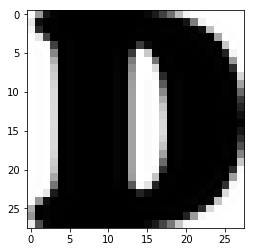

In [396]:
import os
import tarfile
from os import path
from scipy import ndimage

def extract(filename, suffix):
    root = path.splitext(path.splitext(filename)[0])[0]
    if not path.isdir(root + suffix):
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()


def load(folder, h=28, w=28):
    labels = [chr(ord('A') + i) for i in range(10)]
    X, Y = [], []
    for label in labels:
        for image in os.listdir(path.join(folder, label)):
            image_file = path.join(folder, label, image)
            try: 
                image_data = (plt.imread(image_file).astype(float) - 255.0 / 2) / 255.0
                X.append(image_data)
                Y.append(ord(label) - ord('A'))
            except IOError:
                print(f'failed to load {image_file}')
    
    X, Y = np.array(X), np.array(Y)
    return X, Y


extract('notMNIST.tar.gz', '_small')
X, Y = load('notMNIST_small')


plt.imshow(X[7331], cmap='Greys')

In [432]:
import keras

x_train, y_train = X, Y
x_test, y_test = X, Y

### Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalMaxPool2D

resolution = 28
classes = 10
batch_size = 128
# Creating a Sequential Model and adding the layers
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x=x_train,y=y_train, epochs=15)

x_train shape: (18724, 28, 28, 1)
Number of images in x_train 18724
Number of images in x_test 18724
Epoch 1/15
18724/18724 [==============================] - 35s 2ms/step - loss: 1.3424 - acc: 0.5330
Epoch 2/15
18724/18724 [==============================] - 27s 1ms/step - loss: 0.8376 - acc: 0.7345
Epoch 3/15
18724/18724 [==============================] - 27s 1ms/step - loss: 0.6774 - acc: 0.7907
Epoch 4/15
18724/18724 [==============================] - 28s 2ms/step - loss: 0.5934 - acc: 0.8174
Epoch 5/15
18724/18724 [==============================] - 27s 1ms/step - loss: 0.5500 - acc: 0.8303
Epoch 6/15
18724/18724 [==============================] - 26s 1ms/step - loss: 0.5010 - acc: 0.8431
Epoch 7/15
18724/18724 [==============================] - 30s 2ms/step - loss: 0.4754 - acc: 0.8498
Epoch 8/15
18724/18724 [==============================] - 31s 2ms/step - loss: 0.4439 - acc: 0.8600
Epoch 9/15
18724/18724 [==============================] - 31s 2ms/step - loss: 0.4343 - acc: 0.8653